## Sampling and resampling

The "Nyquist-Shannon sampling theorem" (https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem;
Shannon 1949) lays out the theoretical foundation for recording continuous signal (like visual images)
as discrete samples (like pixels).

Key elements are the "sampling theorem" (aka "Nyquist sampling"):

"""
If a function `x(t)` contains no frequencies higher than `B` hertz, it is completely determined by
giving discrete samples at a series of points spaced 1/(2B) seconds apart.
"""

Once we have discrete samples, a "reconstruction" formula allows us to reproduce the original continuous signal.
Theoretically, this involves treating the discrete samples as a train of weighted delta functions,
which we then low-pass filter to remove high-frequency aliases ("anti-aliasing").  The ideal low-pass filter
is a top-hat in frequency (Fourier) space (low frequencies pass through unaltered; high frequencies are zeroed out).  In real space, the top-hat is a `sinc` function.  So a reconstruction formula for `x(t)` given samples
`x_i` is:

$x(t) = \sum_{i=-\infty}^{+\infty} x_i \, \textrm{sinc}\left(\frac{t - i T}{T}\right)$

where $T$ is the time between samples.

This also allows us to *shift* the original signal by evaluating the reconstruction function at points
other than the discrete samples.

Since the `sinc` has infinite support, in practice we
use approximations to `sinc` that have "compact support".  A very common choice in audio and image processing
are the "Lanczos" kernels (Lanczos 1956), which are like the `sinc` function but go to zero outside a window.
The Lanczos-n filter is

$L_n(t) = n \frac{sin(\pi t) sin(\pi t / n)}{\pi^2 t^2}$

(and $1$ at $t=0$, and $0$ outside the range $\pm n$).

A very common choice for $n$ is $3$ (Lanczos-3).

In [1]:
# For the astronomy application we're going to do below, we'll need these new packages.

In [2]:
] add WCS FITSIO

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %35.6 %>           ]  71.5 % Resolving package versions...
 Installed Parsers ──────── v1.0.1
 Installed DataStructures ─ v0.17.11
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [864edb3b] ↑ DataStructures v0.17.10 ⇒ v0.17.11
  [69de0a69] ↑ Parsers v1.0.0 ⇒ v1.0.1


In [3]:
using Images
using Plots
using TestImages

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1273
  likely near /Users/dstn/.julia/packages/Images/RUVAg/src/Images.jl:60
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


In [4]:
function lanczos3(x)
    if x < -3 || x > +3
        0.
    elseif x == 0
        1.
    else
        3 * sin(pi * x) * sin(pi * x / 3) / (pi^2 * x^2)
    end
end

lanczos3 (generic function with 1 method)

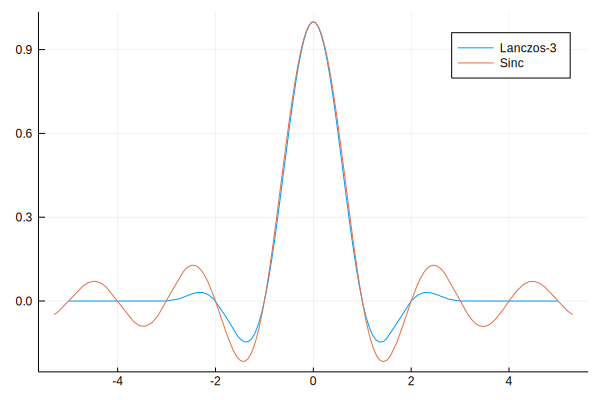

In [5]:
plot(lanczos3, label="Lanczos-3")
plot!(sinc, label="Sinc")

How do we use the Lanczos kernel to *shift* a discrete signal?  First *evaluate* the Lanczos kernel offset
by the desired shift, then *convolve* it with the samples.

In [6]:
function lanczos3_shift(samples, sx)
    # "sx": float pixel position within "samples" array at which to evaluate the signal.
    # "cx": rounded to the nearest integer
    cx = round(Int, sx)
    conv = 0.
    for x = cx-3: cx+3
        if x < 1 || x > length(samples)
            continue
        end
        s = samples[x]
        weight = lanczos3(sx - x)
        conv += s * weight
    end
    conv
end

lanczos3_shift (generic function with 1 method)

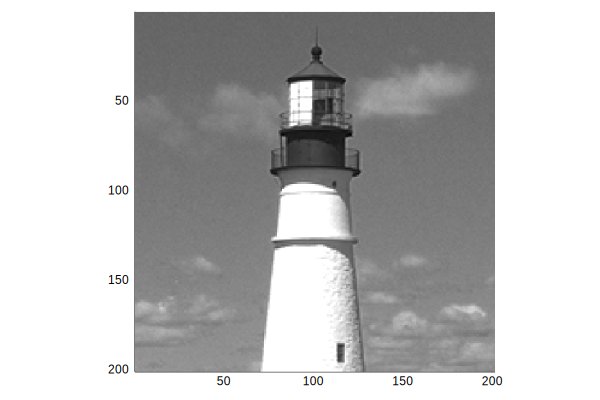

In [7]:
img = testimage("lighthouse")
red = Float32.(channelview(img))[1,50:250,250:450]
plot(Gray.(red))

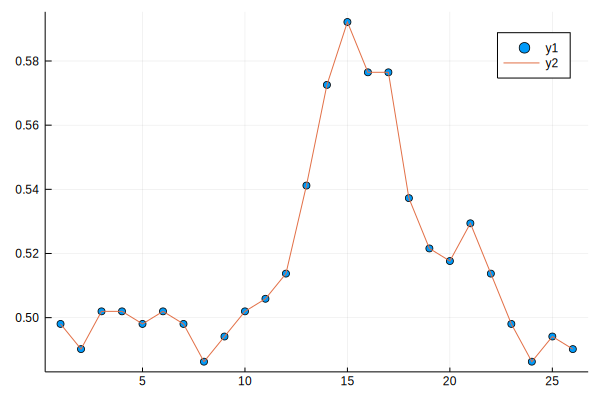

In [8]:
#samples = img[400, 385:425]
samples = red[125:150, 150]
plot(samples, seriestype=:scatter)
plot!(samples)

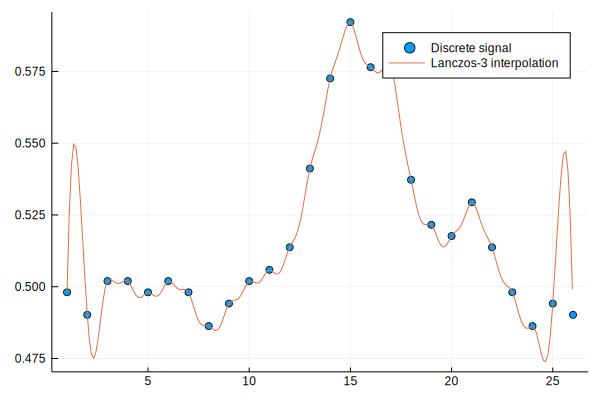

In [9]:
plot(samples, seriestype=:scatter, label="Discrete signal")
xx = 1:0.11:length(samples)
s = [lanczos3_shift(samples, x) for x in xx];
plot!(xx, s, label="Lanczos-3 interpolation")

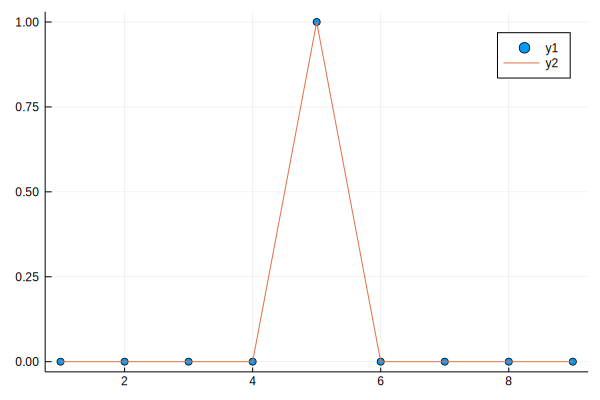

In [10]:
samples2 = [0,0,0,0,1,0,0,0,0]
plot(samples2, seriestype=:scatter)
plot!(samples2)

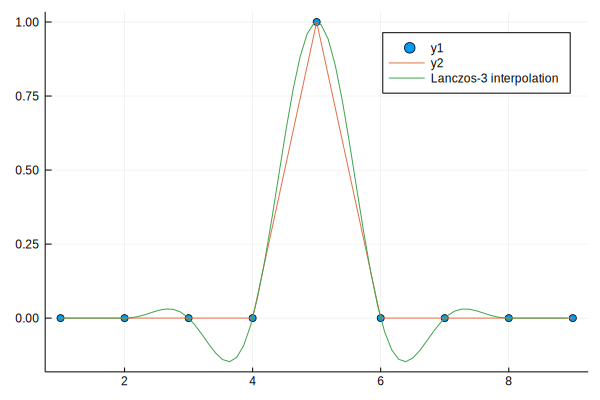

In [11]:
xx = 1:0.11:length(samples2)
s = [lanczos3_shift(samples2, x) for x in xx];
plot!(xx, s, label="Lanczos-3 interpolation")

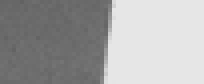

In [12]:
#Gray.(20. * img[275:325, 325:375])
Gray.(red[140:160, 50:100] .- 0.1)

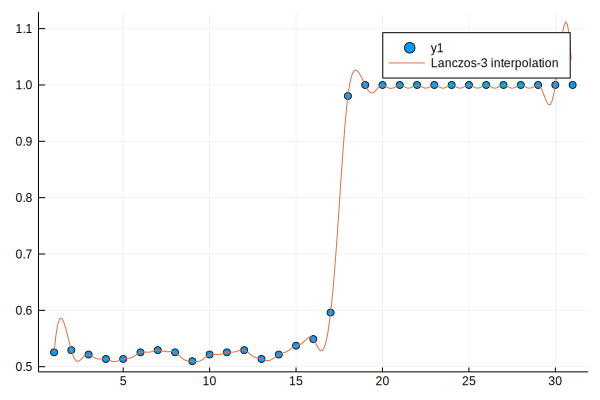

In [13]:
#samples2 = img[400:475, 350]
#samples2 = img[285:300, 350]
samples2 = red[150, 60:90]
plot(samples2, seriestype=:scatter)
xx = 1:0.11:length(samples2)
s = [lanczos3_shift(samples2, x) for x in xx];
plot!(xx, s, label="Lanczos-3 interpolation")

In [14]:
function lanczos3_shift_2d(samples, sx, sy)
    # "sx","sy": float pixel coordinates within "samples" image at which to evaluate the signal.
    # The Lanczos kernel is separable, so we'll first run along rows, then columns.
    H,W = size(samples)
    shifted_row = []
    # "cy": rounded to the nearest integer
    cy = round(Int, sy)
    for y = cy-3: cy+3
        if y < 1 || y > H
            sh = 0.
        else
            # Grab out one row of data and resample it at the column position 'sx'.
            sh = lanczos3_shift(samples[y, :], sx)
        end
        append!(shifted_row, sh)
    end
    lanczos3_shift(shifted_row, sy-(cy-3))
end

lanczos3_shift_2d (generic function with 1 method)

In [15]:
angle = 15.
rangle = deg2rad(angle);

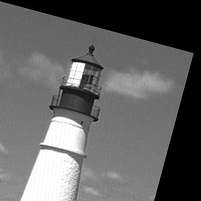

In [16]:
H,W = size(red)
resampled = zeros((H,W))
for y = 1:H
    for x = 1:W
        rx =  cos(rangle) * x + sin(rangle) * y
        ry = -sin(rangle) * x + cos(rangle) * y
        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)

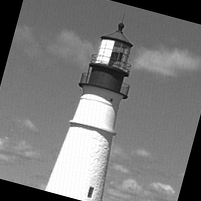

In [17]:
resampled = zeros((H,W))
for y = 1:H
    for x = 1:W
        dx = (x - W/2)
        dy = (y - H/2)
        rx = W/2 +  cos(rangle) * dx + sin(rangle) * dy
        ry = H/2 + -sin(rangle) * dx + cos(rangle) * dy
        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)

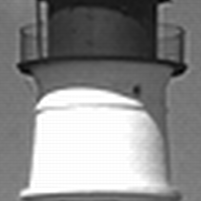

In [18]:
resampled = zeros((H,W))
for y = 1:H
    for x = 1:W
        dx = (x - W/2)
        dy = (y - H/2)
        rx = W/2 + dx * 0.3
        ry = H/2  + dy * 0.3
        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)

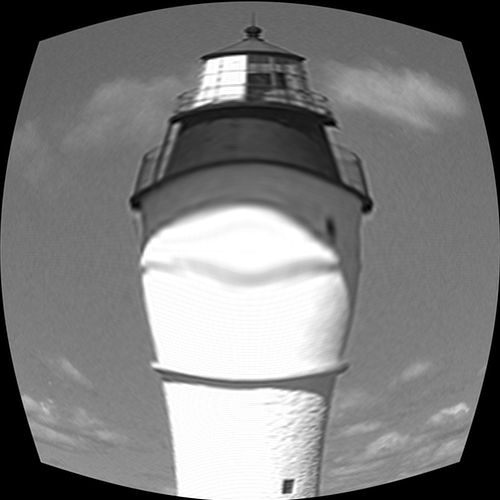

In [19]:
rH,rW = 500,500
resampled = zeros((rH,rW))
for y = 1:rH
    for x = 1:rW
        fx = 2 * (x / rW - 0.5)
        fy = 2 * (y / rH - 0.5)
        r = max(hypot(fx, fy), 0.001)
        rx = (r^2 * (fx/r) / 2 + 0.5) * W
        ry = (r^2 * (fy/r) / 2 + 0.5) * H
        #rx = (sqrt(r) * (fx/r) / 2 + 0.5) * W
        #ry = (sqrt(r) * (fy/r) / 2 + 0.5) * H
        rpixel = lanczos3_shift_2d(red, rx, ry)
        resampled[y,x] = rpixel
    end
end
Gray.(resampled)

## Resampling astronomical images

Last time, we took an astronomical image observed in different bands, and detected *stars* to align
the images to the nearest pixel, and we assumed no rotation (which was reasonable for the SDSS camera
we were considering, but not in general).

In typical astronomical data processing, we detect stars (to sub-pixel accuracy), and align them to known
*reference* stars (eg, detected by the Gaia satellite).  From this, we can build up a function that maps
pixel positions to positions on the sky -- Right Ascension (RA) and Declination (Dec).

This mapping between RA,Dec and pixel x,y is called a "World Coordinate System" (WCS).

WCS mappings for professional astronomy surveys often include, say, 3rd-order polynomial corrections for the
distortions in the camera.

For our work today, I have pulled out sub-images from a few hundred exposures taken by the Dark Energy Survey (DES) from this part of the sky:
http://legacysurvey.org/viewer/?ra=41.4289&dec=-0.5375&layer=dr8&zoom=14

We're going to resample these images to bring them to the same pixel grid, and add the images together to detect fainter and fainter stars and galaxies.

In [20]:
using FITSIO
using WCS

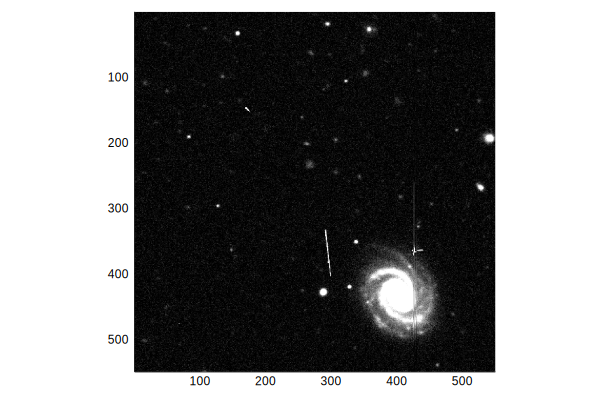

In [103]:
# Read the FITS pixel data:
filename = "data/image-g-000.fits"
f = FITS(filename)
img = transpose(read(f[1]))
plot(Gray.(20. * img))

To show our results today, we're going to use a slightly more sophisticated "stretch" function for
producing RGB images from these three bands.  You don't need to understand this function...

In [248]:
function astro_rgb(g, r, z)
    g = max.(g .* 30. .+ 0.03, 0.)
    r = max.(r .* 17. .+ 0.03, 0.)
    z = max.(z .* 11. .+ 0.03, 0.)
    I = (g .+ r .+ z) ./ 3.
    Q = 20.
    fI = asinh.(Q .* I) ./ sqrt(Q)
    I = max.(I, 1e-6)
    I = fI ./ I
    g = g .* I
    r = r .* I
    z = z .* I
    return colorview(RGB, z, r, g)
end

astro_rgb (generic function with 1 method)

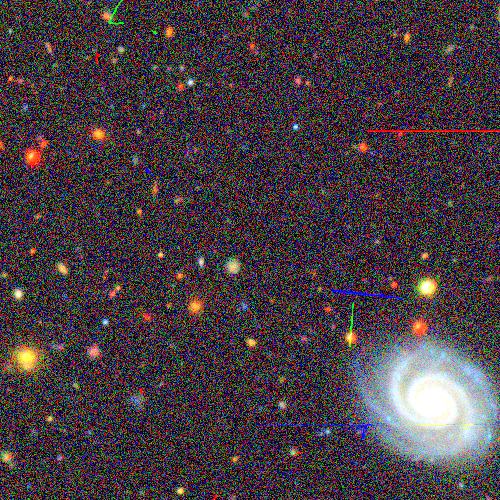

In [249]:
g = read(FITS("data/image-g-000.fits")[1])[1:500, 1:500]
r = read(FITS("data/image-r-000.fits")[1])[1:500, 1:500]
z = read(FITS("data/image-z-000.fits")[1])[1:500, 1:500];
astro_rgb(g,r,z)

I have chosen the "stretch" of this image to be fairly noisy in these single images; we will see that
this noise will be considerably reduced when we add together multiple images.

You can see the great diversity of star and galaxy colors!

You can also see the significant number of cosmic ray hits that contaminate our images!

Next, we're going to try reading and playing with some World Coordinate System objects.  The library
for doing this is slightly awkward...

In [250]:
function read_wcs(filename)
    io = open(filename, "r")
    hdr_str = String(read(io, 2880))
    wcs = WCS.from_header(hdr_str, ignore_rejected=true)[1]
end

read_wcs (generic function with 1 method)

In [251]:
# Reading the WCS header is more awkward.... the "WCS" library does not seem to play nice with the
# "FITSIO" library, so we re-read the header...
wcs = read_wcs(filename)

WCSTransform(naxis=2)

In [252]:
# pix_to_world transforms from pixel coordinates to "world" coordinates (RA,Dec in this case)
r,d = pix_to_world(wcs, [440., 400.])

2-element Array{Float64,1}:
 41.42918328183962  
 -0.5420457564476103

In [253]:
# Unsurprisingly, world_to_pix() transforms from RA,Dec back to pixels.
world_to_pix(wcs, [r, d])

2-element Array{Float64,1}:
 439.999999999994  
 400.00000000002115

Using World Coordinate System transformation, we can convert between the pixel coordinates of two different
images by converting pixels to sky (using the first WCS) and then sky to pixels (using the second WCS).

We could use one of the images as our target WCS, but instead we're going to define an exact WCS for the chunk of sky we're interested in.

This simple WCS header is a "TAN"gent plane projection, around a specified "reference" RA,Dec point and pixel coordinate, and with a given pixel scale.

In [254]:
# This pixel scale matches that of the Dark Energy Camera, where these data come from.
pixel_scale = 7.277e-5
target_wcs = WCSTransform(2;
                          cdelt = [-pixel_scale, pixel_scale],
                          ctype = ["RA---TAN", "DEC--TAN"],
                          crpix = [275., 275.],
                          crval = [41.42, -0.53],)

WCSTransform(naxis=2)

In [255]:
using Printf

Now, using the WCS transformations to map between pixel grids, and
our Lanczos-3 interpolation routine from above to interpolate,
we're going to sum up 4 images in each of our three bands.

In [246]:
# The output image we're going to create...
coH,coW = 550, 550
coadd_g = zeros((coH, coW))
coadd_r = zeros((coH, coW))
coadd_z = zeros((coH, coW))
coweight = zeros((coH, coW));

# We're going to sum 4 images in each of the "g", "r" and "z" bands,
# creating a "coadd" (sum) of each.
for n = 0:3
    filename = @sprintf("data/image-g-%03i.fits", n)
    println("Reading ", filename)
    f = FITS(filename)
    img_g = transpose(read(f[1]))
    wcs_g = read_wcs(filename)

    filename = @sprintf("data/image-r-%03i.fits", n)
    println("Reading ", filename)
    f = FITS(filename)
    img_r = transpose(read(f[1]))
    wcs_r = read_wcs(filename)

    filename = @sprintf("data/image-z-%03i.fits", n)
    println("Reading ", filename)
    f = FITS(filename)
    img_z = transpose(read(f[1]))
    wcs_z = read_wcs(filename)

    # For each pixel of our output image:
    for oy in 1:coH
        for ox in 1:coW
            # Convert output pixel to sky coordinates
            ra,dec = pix_to_world(target_wcs, [ox+0. , oy+0.])

            # Convert sky coords back to pixel coordinates in our input image.
            ix,iy = world_to_pix(wcs_g, [ra, dec])
            coadd_g[oy,ox] += lanczos3_shift_2d(img_g, ix, iy)

            ix,iy = world_to_pix(wcs_r, [ra, dec])
            coadd_r[oy,ox] += lanczos3_shift_2d(img_r, ix, iy)

            ix,iy = world_to_pix(wcs_z, [ra, dec])
            coadd_z[oy,ox] += lanczos3_shift_2d(img_z, ix, iy)
            
            coweight[oy,ox] += 1.
        end
    end
end

Reading data/image-g-000.fits
Reading data/image-r-000.fits
Reading data/image-z-000.fits
Reading data/image-g-001.fits
Reading data/image-r-001.fits
Reading data/image-z-001.fits
Reading data/image-g-002.fits
Reading data/image-r-002.fits
Reading data/image-z-002.fits
Reading data/image-g-003.fits
Reading data/image-r-003.fits
Reading data/image-z-003.fits


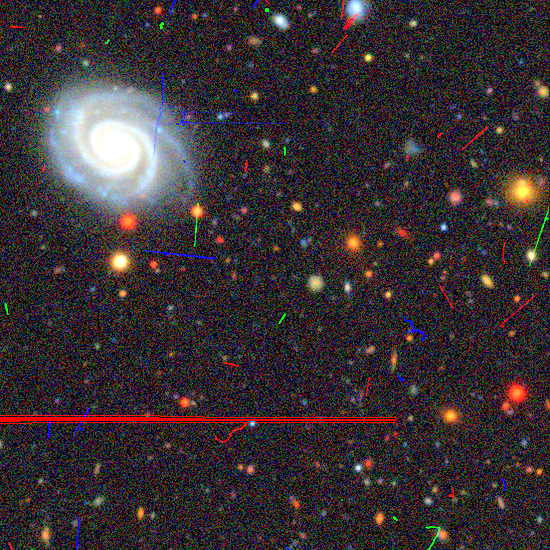

In [256]:
astro_rgb(coadd_g ./ coweight, coadd_r ./ coweight, coadd_z ./ coweight)

Comparing this with the image above (made from only a single input image in each band),
you can see that the noise level is smaller (it should be 2x smaller, since we averaged 4
images); and we begin to see more and more faint stars and galaxies discernable above the noise.

I generated a set of 100 images in each of the three bands, but we would need to make some code
improvements to handle those in a reasonable amount of time!  The WCS operations take a considerable
amount of time, so one approach would be to build a local linear interpolation between each WCS grid and
our target WCS.  This is an Exercise Left For Student!
